# Модель 23

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Импорт необходимых библиотек

In [2]:
!pip install tensorflow-addons
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%cd drive/MyDrive/YaMlProject/models/models

/content/drive/MyDrive/YaMlProject/models/models


In [1]:
import sys
import pickle

import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from livelossplot import PlotLossesKeras

sys.path.append('../../')

from core.datasets import get_ds
from core.make_answer import make_ans_file

c:\Users\Mi\Desktop\ML\.conda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
num_model = '_g_23'

#### Аугментация (4)

In [3]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-10, 10), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

#### Скачиваем датасеты

In [4]:
train_ds, val_ds, test_ds = get_ds(
    'smote_data_train_7000', 'repaired_data_test',
    transform=transformer, one_hot=True, back=2, batch_size=100
)

Для дальнейшей проверки метрик разделяем валидационный датасет на x и y

In [5]:
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])

Смотрим на получившуюся агументацию.

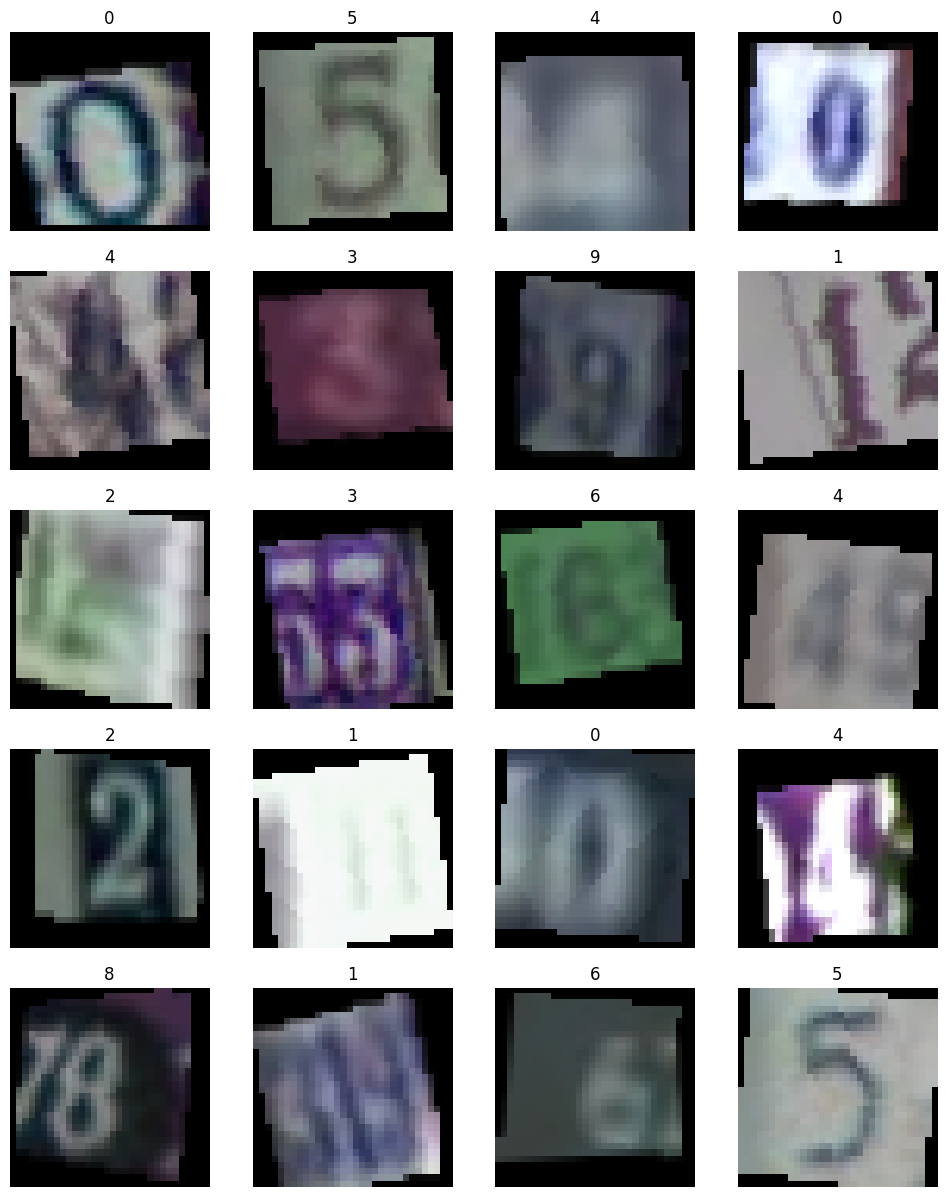

In [6]:
plt.figure(figsize=(12, 15))
train_ds_visualization = train_ds[0]
for i in range(20):
    plt.subplot(5, 4, i + 1)
    img = np.array(Image.fromarray((train_ds_visualization[0][i] * 255).astype(np.uint8), 'RGB'))
    plt.imshow(img / 255, cmap=plt.cm.binary)
    plt.title(np.argmax(train_ds_visualization[1][i]))
    plt.axis('off')
plt.show()

#### Пишем модель

In [7]:
inputs = tf.keras.layers.Input((32, 32, 3), 100)

inp = tf.keras.layers.Conv2D(32, 3, use_bias=False)(inputs)
x = tf.keras.layers.Conv2D(32, 1, strides=1, padding='same', use_bias=False)(inp)
x = tf.keras.layers.DepthwiseConv2D(3, strides=1, padding='same', use_bias=False)(x)
x = tf.keras.layers.Conv2D(32, 1, strides=1, padding='same', use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(6)(x)
x = tf.keras.layers.Add()([inp, x])

x = tf.keras.layers.Dropout(0.25)(x)

inp = tf.keras.layers.Conv2D(64, 4, 2, use_bias=False)(x)
x = tf.keras.layers.Conv2D(64, 1, strides=1, padding='same', use_bias=False)(inp)
x = tf.keras.layers.DepthwiseConv2D(3, strides=1, padding='same', use_bias=False)(x)
x = tf.keras.layers.Conv2D(64, 1, strides=1, padding='same', use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(6)(x)
x = tf.keras.layers.Add()([inp, x])

x = tf.keras.layers.Dropout(0.25)(x)

inp = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 1, strides=1, padding='same', use_bias=False)(inp)
x = tf.keras.layers.DepthwiseConv2D(3, strides=1, padding='same', use_bias=False)(x)
x = tf.keras.layers.Conv2D(64, 1, strides=1, padding='same', use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(6)(x)
x = tf.keras.layers.Add()([inp, x])

inp = tf.keras.layers.Conv2D(128, 4, 2, use_bias=False)(x)
x = tf.keras.layers.Conv2D(128, 1, strides=1, padding='same', use_bias=False)(inp)
x = tf.keras.layers.DepthwiseConv2D(3, strides=1, padding='same', use_bias=False)(x)
x = tf.keras.layers.Conv2D(128, 1, strides=1, padding='same', use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(6)(x)
x = tf.keras.layers.Add()([inp, x])

In [8]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(100, 'relu')(x)
x = tf.keras.layers.Dense(10)(x)
model = tf.keras.models.Model(inputs=inputs, outputs=x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(100, 32, 32, 3)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (100, 30, 30, 32)    864         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (100, 30, 30, 32)    1024        ['conv2d[0][0]']                 
                                                                                                  
 depthwise_conv2d (DepthwiseCon  (100, 30, 30, 32)   288         ['conv2d_1[0][0]']               
 v2D)                                                                                         

#### Создаем чекпоинты

In [9]:
metrics = ['categorical_accuracy',
           tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')]
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    ),

    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    )
]

#### Компиляция модели

In [10]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * tf.math.exp(-0.03)


callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))

In [11]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam(0.0016, decay=5e-6)),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

#### Обучаем модель

In [12]:
history = model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

Epoch 1/100
651/651 [==============================] - 444s 669ms/step - loss: 1.2874 - categorical_accuracy: 0.5619 - f1_score: 0.5594 - val_loss: 0.7205 - val_categorical_accuracy: 0.7707 - val_f1_score: 0.7720 - lr: 0.0016
Epoch 2/100
195/651 [=======>......................] - ETA: 4:55 - loss: 0.6877 - categorical_accuracy: 0.7789 - f1_score: 0.7778

Подгружаем все чекпоинты

In [7]:
model_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_categorical_accuracy.h5')
model_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_f1_score.h5')
model_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_loss.h5')
model_avg_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5')
model_avg_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_f1_score.h5')
model_avg_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_loss.h5')

У нас поличилось шесть чекпоинта (шесть моделей). Ниже указан код для получения ответов для всех чекпоинтов по валидационному датасету.

In [8]:
ans_val_categorical_accuracy = make_ans_file(model_categorical_acc, val_ds_x)
ans_val_f1_score = make_ans_file(model_f1_score, val_ds_x)
ans_val_loss = make_ans_file(model_loss, val_ds_x)
ans_val_avg_categorical_accuracy = make_ans_file(model_avg_categorical_acc, val_ds_x)
ans_val_avg_f1_score = make_ans_file(model_avg_f1_score, val_ds_x)
ans_val_avg_loss = make_ans_file(model_avg_loss, val_ds_x)
anss = [ans_val_categorical_accuracy, ans_val_f1_score, ans_val_loss, ans_val_avg_categorical_accuracy, ans_val_avg_f1_score, ans_val_avg_loss]

154/154 [==============================] - 98s 618ms/step


Формируем валидационные ответы.

In [9]:
val_ds_y = np.argmax(val_ds_y, axis=1)

Сравниваем валидационные предикты каждого чекпоинта

In [10]:
for i in range(len(anss) - 1):
    for j in range(i + 1, len(anss)):
        if np.all(anss[i] == anss[j]):
            print(f'чекпоинты {i + 1} и {j + 1} одинаковые')

чекпоинты 1 и 2 одинаковые
чекпоинты 4 и 5 одинаковые


Рассмотрим только 1, 3, 4, 6

## ВЫВОД:

In [11]:
class MulticlassClassificationMetrics:
    def __init__(self, y_true, y_pred):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.matrix_error = self.get_matrix_error()

    def get_matrix_error(self):
        self.class_types = np.unique([self.y_true, self.y_pred])
        TP, FN, FP, TN = [], [], [], []
        for class_type in self.class_types:
            TP.append(np.sum(np.logical_and(self.y_true == self.y_pred, self.y_true == class_type)))
            FN.append(np.sum(np.logical_and(self.y_true == class_type, self.y_pred != class_type)))
            FP.append(np.sum(np.logical_and(self.y_pred == class_type, self.y_true != class_type)))
            TN.append(np.sum(np.logical_and(self.y_pred != class_type, self.y_true != class_type)))
        return pd.DataFrame({
            'class_type': self.class_types,
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        }).set_index('class_type')

    def accuracy(self):
        return np.sum(self.y_true == self.y_pred) / self.y_true.shape[0]

    def precision(self, averaging='macro'):
        if averaging == 'macro':
            precisions = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FP'])
            return np.mean(precisions.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FP'])

    def recall(self, averaging='macro'):
        if averaging == 'macro':
            recalls = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FN'])
            return np.mean(recalls.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FN'])

    def f1_score(self, averaging='macro'):
        if averaging == 'macro':
            reverse_r = (self.matrix_error['TP'] + self.matrix_error['FN']) / self.matrix_error['TP']
            reverse_p = (self.matrix_error['TP'] + self.matrix_error['FP']) / self.matrix_error['TP']
            f1_scores = 2 / (reverse_r + reverse_p)
            return np.mean(f1_scores.replace(np.nan, 0))
        elif averaging == 'micro':
            p = self.precision(averaging)
            r = self.recall(averaging)
            return 2 * p * r / (p + r)

    def metrics(self, averaging='macro'):
        return {
            'accuracy': self.accuracy(),
            'precision': self.precision(averaging),
            'recall': self.recall(averaging),
            'f1_score': self.f1_score(averaging),
        }

    def __str__(self):
        headers = {
            'selector': '*',
            'props': 'background-color: darkgreen; color: white; font-size: 12pt;',
        }
        che_super_mega_puper_visualization_of_cell = { 
            'selector': 'td:hover',
            'props': 'background-color: green; color: white;',
        }
        display(
            self.matrix_error
            .style
            .set_table_styles([
                headers,
                che_super_mega_puper_visualization_of_cell,
            ])
            .set_properties(**{'background-color': 'lightgreen',
                           'color': 'black', 'font-size': '12pt'})
        )
        return ''

    def __repr__(self):
        return (
            f'MulticlassClassificationMetrics(class_types={self.class_types})'
            .replace("'", '').replace(',', ';'))

### Accuracy чекпоинт

In [12]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,456,4444,0,1
1,463,4435,1,2
2,482,4415,2,2
3,484,4416,1,0
4,496,4405,0,0
5,528,4372,0,1
6,495,4405,1,0
7,491,4410,0,0
8,486,4413,2,0


{'accuracy': 0.9983676800652928,
 'precision': 0.9983586933084359,
 'recall': 0.9983597099766884,
 'f1_score': 0.9983581534681522}

## F1-score чекпоинт

In [13]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,453,4433,11,4
1,454,4419,17,11
2,481,4395,22,3
3,460,4413,4,24
4,483,4405,0,13
5,528,4355,17,1
6,475,4399,7,20
7,483,4405,5,8
8,477,4407,8,9


{'accuracy': 0.9800040807998368,
 'precision': 0.9801819300381137,
 'recall': 0.97987627258331,
 'f1_score': 0.979882236234436}

## Скользящее среднее по accuracy чекпоинт

In [14]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,457,4444,0,0
1,463,4435,1,2
2,482,4415,2,2
3,484,4415,2,0
4,496,4405,0,0
5,527,4372,0,2
6,495,4406,0,0
7,491,4410,0,0
8,486,4413,2,0


{'accuracy': 0.9983676800652928,
 'precision': 0.9983549691449272,
 'recall': 0.9983894924406084,
 'f1_score': 0.9983708177142839}

### Скользящее среднее по F1-score чекпоинт.

In [15]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,453,4443,1,4
1,459,4425,11,6
2,478,4410,7,6
3,474,4410,7,10
4,491,4403,2,5
5,524,4364,8,5
6,489,4399,7,6
7,486,4406,4,5
8,483,4412,3,3


{'accuracy': 0.9889818404407263,
 'precision': 0.9890081598943083,
 'recall': 0.9889494294537917,
 'f1_score': 0.9889719471152045}

Метрики неплохие

- Сохраняем ответы.

In [3]:
log_ans = [f'model{num_model}_categorical_accuracy.h5',
           f'model{num_model}_loss.h5',
           f'model{num_model}_avg_categorical_accuracy.h5',
           f'model{num_model}_avg_loss.h5']
for i in log_ans:
    pred = np.argmax(pickle.load(open(f'../checkpoint_answers/{i}', 'rb')), axis=-1)
    pred = pd.DataFrame({'Id': np.arange(pred.shape[0]), 'Category': pred})
    pred.to_csv(f'../answers/{i[:-3]}.csv', index=False)

Проверяем ответы (одинаковые они или нет), чтоб не терять кол-во отправок ответов на kaggle в день.

Все ответы разные, поэтому отправляем все на kaggle `categorical_accuracy`, `loss`, `avg_categorical_accuracy`, `avg_loss` чекпоинты